# Introduction to Cloud Machine Learning with Flask API and CNTK

One of the best ways to operationalize a machine learning system is through an API. In this notebook we show how to deploy scalable CNTK models for image classification through an API. The frameworks used in the solution are:

* [CNTK](https://github.com/Microsoft/CNTK/): Microsoft's Cognitive Toolkit is the deep learning library we used to compute the [Convolutional Neural Network](https://miguelgfierro.com/blog/2016/a-gentle-introduction-to-convolutional-neural-networks/) (CNN) model that identifies images.
* [Flask](http://flask.pocoo.org/) is one of the most popular frameworks to develop APIs in python. 
* [CherryPy](http://cherrypy.org/) is a lightweight web framework for python. We use it as a web server to host the machine learning application.  

Here we present an overview of the application. The main procedure is executed by the CNTK CNN. The network is a [pretrained ResNet with 152 layers](https://www.cntk.ai/Models/Caffe_Converted/ResNet152_ImageNet.model). The CNN was trained on [ImageNet dataset](http://www.image-net.org/), which contains 1.2 million images divided into 1000 different classes. The CNN is accessible through the flask API, which provides an end point `/api/v1/classify_image` that can be called to classify an image. CherryPy is is the server framework where the application is hosted. It also balances the load, in such a way that several concurrent queries can be executed. Externally, there is the client that can be any desktop or mobile that sends an image to the application to be analyzed and receives the response.   

<p style="center;">
<img src="https://miguelgfierro.com/img/upload/2017/04/17/api_overview_350.png" />
</p>





In [1]:
#load libraries
import os,sys
import pkg_resources
from flask import Flask, render_template, request, send_file
import numpy as np
from PIL import Image, ImageOps
from urllib.request import urlretrieve
import requests
from cntk import load_model, combine
from io import BytesIO, StringIO
import base64
from IPython.core.display import display, HTML
import aiohttp
import asyncio
import json
import random

print("System version: {}".format(sys.version))
print("Flask version: {}".format(pkg_resources.get_distribution("flask").version))
print("CNTK version: {}".format(pkg_resources.get_distribution("cntk").version))

System version: 3.5.3 |Continuum Analytics, Inc.| (default, Mar  6 2017, 11:58:13) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Flask version: 0.12.1
CNTK version: 2.0rc2


In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
#import wget

## Image classification with a pretrained CNTK model
The first step is to download a pretrained model. CNTK has a wide range of [different pretrained models](https://github.com/Microsoft/CNTK/tree/master/Examples/Image/Classification) that can be used for image classification.



In [3]:
def maybe_download_model(filename='ResNet_18.model'):
    if(os.path.isfile(filename)):
        print("Model %s already downloaded" % filename)
    else:
        model_name_to_url = {
        'AlexNet.model':   'https://www.cntk.ai/Models/AlexNet/AlexNet.model',
        'AlexNetBS.model': 'https://www.cntk.ai/Models/AlexNet/AlexNetBS.model',
        'VGG_16.model': 'https://www.cntk.ai/Models/Caffe_Converted/VGG16_ImageNet.model',
        'VGG_19.model': 'https://www.cntk.ai/Models/Caffe_Converted/VGG19_ImageNet.model',
        'InceptionBN.model': 'https://www.cntk.ai/Models/Caffe_Converted/BNInception_ImageNet.model',
        'ResNet_18.model': 'https://www.cntk.ai/Models/ResNet/ResNet_18.model',
        'ResNet_50.model': 'https://www.cntk.ai/Models/Caffe_Converted/ResNet50_ImageNet.model',
        'ResNet_101.model': 'https://www.cntk.ai/Models/Caffe_Converted/ResNet101_ImageNet.model',
        'ResNet_152.model': 'https://www.cntk.ai/Models/Caffe_Converted/ResNet152_ImageNet.model'
        }
        url = model_name_to_url[filename] 
        wget.download(url, out=filename)

For this example we are going to use ResNet with 152 layers, which has a top-5 error of 6.71% in ImageNet.

In [4]:
%%time
model_name = 'ResNet_152.model'
IMAGE_MEAN = 0 # in case the CNN rests the mean for the image
maybe_download_model(model_name)

Model ResNet_152.model already downloaded
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.89 ms


Together with the model, we need the classification information. The [synsets file](synsets.txt) maps the output of the network, which is an number between 0 and 999, with the class name.

In [5]:
def read_synsets(filename='synsets.txt'):
    with open(filename, 'r') as f:
        synsets = [l.rstrip() for l in f]
        labels = [" ".join(l.split(" ")[1:]) for l in synsets]
    return labels

labels = read_synsets()
print("Label length: ", len(labels))
print(labels[:5])

Label length:  1000
['tench, Tinca tinca', 'goldfish, Carassius auratus', 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'tiger shark, Galeocerdo cuvieri', 'hammerhead, hammerhead shark']


Next we are going to prepare some helper functions to read images with PIL and plot them.

In [6]:
def read_image_from_file(filename):
    img = Image.open(filename)
    return img
def read_image_from_ioreader(image_request):
    img = Image.open(BytesIO(image_request.read())).convert('RGB')
    return img
def read_image_from_request_base64(image_base64):
    img = Image.open(BytesIO(base64.b64decode(image_base64)))
    return img
def read_image_from_url(url):
    img = Image.open(requests.get(url, stream=True).raw)
    return img

In [7]:
def plot_image(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

Let's test the different input images and plot them.

In [ ]:
imagepath = 'neko.jpg'
img_cat = read_image_from_file(imagepath)
plot_image(img_cat)

In [ ]:
imagefile = open(imagepath, 'rb')
print(type(imagefile))
img = read_image_from_ioreader(imagefile)
plot_image(img)

In [ ]:
imagefile = open(imagepath, 'rb')
image_base64 = base64.b64encode(imagefile.read())
print("String of %d characters" % len(image_base64))
img = read_image_from_request_base64(image_base64)
plot_image(img)

In [ ]:
imageurl = 'https://pbs.twimg.com/profile_images/269279233/llama270977_smiling_llama_400x400.jpg'
img_llama = read_image_from_url(imageurl)
plot_image(img_llama)

Once we have the image, the model file and the sysntets, the next step is to load the model and perform a prediction. We need to process the image to swap the RGB channels and resize to the input size of ImageNet, which is `224x224`.

In [ ]:
%%time
z = load_model(model_name)

In [ ]:
def softmax(vect):
    return np.exp(vect) / np.sum(np.exp(vect), axis=0)

In [ ]:
def get_preprocessed_image(my_image, mean_image):
    #Crop and center the image
    my_image = ImageOps.fit(my_image, (224, 224), Image.ANTIALIAS)
    #Transform the image for CNTK format
    my_image = np.array(my_image, dtype=np.float32)
    # RGB -> BGR
    bgr_image = my_image[:, :, ::-1] 
    image_data = np.ascontiguousarray(np.transpose(bgr_image, (2, 0, 1)))
    image_data -= mean_image
    return image_data

In [ ]:
def predict(model, image, labels, number_results=5):
    img = get_preprocessed_image(image, IMAGE_MEAN)
    # Use last layer to make prediction
    arguments = {model.arguments[0]: [img]}
    result = model.eval(arguments)
    result = np.squeeze(result)
    prob = softmax(result)
    # Sort probabilities 
    prob_idx = np.argsort(result)[::-1][:number_results]
    pred = [labels[i] for i in prob_idx]
    return pred
 

Now let's predict the class of some of the images

In [ ]:
resp = predict(z, img_llama, labels, 2)
print(resp)
resp = predict(z, img_cat, labels, 3)
print(resp)
resp = predict(z, read_image_from_url('http://www.awf.org/sites/default/files/media/gallery/wildlife/Hippo/Hipp_joe.jpg'), labels, 5)
print(resp)

## Set up Flask API

Let´s start the flask server. The code can be found in the file [cntk_api.py](cntk_api.py). To start it in localhost, first set `DEVELOPMENT=True` in the file [config.py](config.py) and execute it inside a cntk environment:

```bash
source activate my-cntk-env
python cntk_api.py
```
You will get something like this:
```bash
* Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)
* Restarting with stat
* Debugger is active!
```
First we will test that the API works locally, for that we created a sample web page [hello.html](templates/hello.html) that is going to be rendered when you call the API root.

The code for this operation is as simple as this:
```python
@app.route('/')
def hello():
    return render_template('hello.html')
```

In order to execute the api from this notebook you can use the magic background function executing the file using the binary in the cntk environment:

In [ ]:
%%bash --bg 
/home/my-user/anaconda3/envs/my-cntk-env/bin/python /home/my-user/sciblog_support/Intro_to_Machine_Learning_API/cntk_api.py

In [ ]:
res = requests.get('http://127.0.0.1:5000/')
display(HTML(res.text))

Flask allows for simple routing of services. Let's create the main end point `/api/v1/classify_image`. The service accepts an image in bytes or in a url. Both requests are converted to a PIL image. In case the request is incorrect the API returns a bad request. The image is analyzed using `predict` method, that returns the top-5 classification results given the CNN model and the labels. Finally everything is formatted as a json.

```python
@app.route('/api/v1/classify_image', methods=['POST'])
def classify_image():
    if 'image' in request.files:
        cherrypy.log("Image request")
        image_request = request.files['image']
        img = read_image_from_ioreader(image_request)
    elif 'url' in request.json: 
        cherrypy.log("JSON request: {}".format(request.json['url']))
        image_url = request.json['url']
        img = read_image_from_url(image_url)
    else:
        cherrypy.log("Bad request")
        abort(BAD_REQUEST)
    resp = predict(model, img, labels, 5)
    return make_response(jsonify({'message': resp}), STATUS_OK)
```


Let's first force a bad request:

In [ ]:
headers = {'Content-type':'application/json'}
data = {'param':'1'}
res = requests.post('http://127.0.0.1:5000/api/v1/classify_image', data=json.dumps(data), headers=headers)
print(res.text)

Now we are going to use the end point with a image from an URL.

In [ ]:
%%time
imageurl = 'https://pbs.twimg.com/profile_images/269279233/llama270977_smiling_llama_400x400.jpg'
data = {'url':imageurl}
res = requests.post('http://127.0.0.1:5000/api/v1/classify_image', data=json.dumps(data), headers=headers)
print(res.text)

Finally, we are going to test the API with an image loaded from disk.

In [ ]:
%%time
imagepath = 'neko.jpg'
image_request = open(imagepath, 'rb')
files_local = {'image': image_request}
res = requests.post('http://127.0.0.1:5000/api/v1/classify_image', files=files_local)
print(res.text)

## CNTK API with CherryPy

There are multiple solutions to setup a production API with Flask. One option is using [Nginx](https://www.nginx.com/) server and [Gunicorn](http://gunicorn.org/) as a load balancer. Here you can find [a great example](https://github.com/ilkarman/CV_end_to_end/blob/master/01-VM/FlaskVM.md) combining these two technologies to serve machine learning models. Another way is to use [Apache](https://en.wikipedia.org/wiki/Apache_HTTP_Server) like in [this example](https://www.vioan.eu/blog/2016/10/10/deploy-your-flask-python-app-on-ubuntu-with-apache-gunicorn-and-systemd/). Here a simple flask application is set up using Apache server and Gunicorn. 

In this notebook we are going to use [CherryPy](http://cherrypy.org/). It has the following features that the authors announce in their web page:

* A reliable, HTTP/1.1-compliant, WSGI thread-pooled webserver. WSGI stands for Web Server Gateway Interface. It is a specification that describes how a web server communicates with web applications, and how web applications can be chained together to process one request.
* CherryPy is now more than ten years old and it is has proven to be very fast and stable. In [this benchmark](https://blog.appdynamics.com/engineering/a-performance-analysis-of-python-wsgi-servers-part-2/) CherryPy is tested against several other solutions.
* Built-in profiling, coverage, and testing support.
* Powerful and easy-to-use [configuration system](http://docs.cherrypy.org/en/latest/basics.html#config). 

All these features make CherryPy a good solution for quickly develop production APIs.

The code to set up the server is fairly simple:

```python
def run_server():
    # Enable WSGI access logging via Paste
    app_logged = TransLogger(app)

    # Mount the WSGI callable object (app) on the root directory
    cherrypy.tree.graft(app_logged, '/')

    # Set the configuration of the web server
    cherrypy.config.update({
        'engine.autoreload_on': True,
        'log.screen': True,
        'log.error_file': "cherrypy.log",
        'server.socket_port': PORT,
        'server.socket_host': '0.0.0.0',
        'server.thread_pool': 50, # 10 is default
    })

    # Start the CherryPy WSGI web server
    cherrypy.engine.start()
    cherrypy.engine.block()
```

To start the server, we need to set `DEVELOPMENT=False` in the file [config.py](config.py) and execute it inside a cntk environment:

```bash
source activate my-cntk-env
python cntk_api.py
```
You will get something like this:

```bash
[16/Apr/2017:17:52:43] ENGINE Bus STARTING
[16/Apr/2017:17:52:43] ENGINE Started monitor thread 'Autoreloader'.
[16/Apr/2017:17:52:43] ENGINE Started monitor thread '_TimeoutMonitor'.
[16/Apr/2017:17:52:43] ENGINE Serving on http://0.0.0.0:5000
[16/Apr/2017:17:52:43] ENGINE Bus STARTED
```
The first step is to test if the root end point is working:

In [8]:
server_name = 'http://localhost'
port = 5000

In [9]:
root_url = '{}:{}'.format(server_name, port)

In [10]:
res = requests.get(root_url)
display(HTML(res.text))

Now, as we did before, let's test the classification API with an image from a URL and an image from bytes.

In [11]:
end_point = root_url + '/api/v1/classify_image' 
#print(end_point)

In [12]:
%%time
imageurl = 'https://pbs.twimg.com/profile_images/269279233/llama270977_smiling_llama_400x400.jpg'
data = {'url':imageurl}
headers = {'Content-type':'application/json'}
res = requests.post(end_point, data=json.dumps(data), headers=headers)
print(res.text)

{
  "message": [
    "llama", 
    "Arabian camel, dromedary, Camelus dromedarius", 
    "patas, hussar monkey, Erythrocebus patas", 
    "chimpanzee, chimp, Pan troglodytes", 
    "ostrich, Struthio camelus"
  ]
}

CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 3.57 s


In [13]:
%%time
imagepath = 'neko.jpg'
image_request = open(imagepath, 'rb')
files = {'image': image_request}
res = requests.post(end_point, files=files)
print(res.text)

{
  "message": [
    "tabby, tabby cat", 
    "Egyptian cat", 
    "tiger cat", 
    "lynx, catamount", 
    "bath towel"
  ]
}

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 1.12 s


## Bombardment
Finally let's do a funny part. Now that we have the API set up with CherryPy, let's test how the system performs under a big number of concurrent requests. The first step is to select the request to execute. We are going to use this handsome hippo.

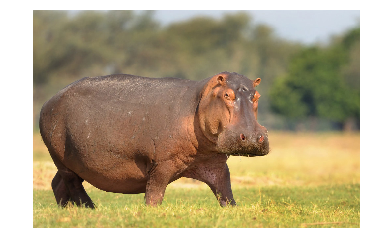

In [14]:
# Get hippo
hippo_url = "http://www.awf.org/sites/default/files/media/gallery/wildlife/Hippo/Hipp_joe.jpg"

fname = urlretrieve(hippo_url, "bhippo.jpg")[0]
img_bomb = read_image_from_file(fname)
plot_image(img_bomb)

Next, we define the number of request and how many of them are concurrent.

In [15]:
NUM = 100
concurrent = 10

We prepare the images for the load test. For that we prepare `NUM` different images, which are modified by one pixel.

In [16]:
def gen_variations_of_one_image(num, filename):
    out_images = []
    imagefile = open(filename, 'rb')
    img = Image.open(BytesIO(imagefile.read())).convert('RGB')
    img = ImageOps.fit(img, (224, 224), Image.ANTIALIAS)
    # Flip the colours for one-pixel
    # "Different Image"
    for i in range(num):
        diff_img = img.copy()
        rndm_pixel_x_y = (random.randint(0, diff_img.size[0]-1), 
                          random.randint(0, diff_img.size[1]-1))
        current_color = diff_img.getpixel(rndm_pixel_x_y)
        diff_img.putpixel(rndm_pixel_x_y, current_color[::-1])
        # Turn image into IO
        ret_imgio = BytesIO()
        diff_img.save(ret_imgio, 'PNG')
        out_images.append(ret_imgio.getvalue())
    return out_images

In [17]:
%%time
# Save same file multiple times in memory as IO
images = gen_variations_of_one_image(NUM, fname)
url_list = [[end_point, {'image':pic}] for pic in images]


CPU times: user 2.67 s, sys: 20 ms, total: 2.69 s
Wall time: 2.72 s


In the following series of functions we define an asynchronous request service. It is in charge of bombarding the end point. 

In [18]:
def handle_req(data):
    return json.loads(data.decode('utf-8'))
 
def chunked_http_client(num_chunks, s):
    # Use semaphore to limit number of requests
    semaphore = asyncio.Semaphore(num_chunks)
    @asyncio.coroutine
    # Return co-routine that will work asynchronously and respect
    # locking of semaphore
    def http_get(dta):
        nonlocal semaphore
        with (yield from semaphore):
            url, img = dta
            response = yield from s.request('post', url, data=img)
            body = yield from response.content.read()
            yield from response.wait_for_close()
        return body
    return http_get

    
def run_experiment(urls, _session):
    http_client = chunked_http_client(num_chunks=concurrent, s=_session)
    
    # http_client returns futures, save all the futures to a list
    tasks = [http_client(url) for url in urls]
    dfs_route = []
    
    # wait for futures to be ready then iterate over them
    for future in asyncio.as_completed(tasks):
        data = yield from future
        try:
            out = handle_req(data)
            dfs_route.append(out)
        except Exception as err:
            print("Error {0}".format(err))
    return dfs_route


Finally, let's run the scalability test. If you take a look at the terminal, you will see the logs with all the requests being executed.

In [19]:
%%time
# Expect to see some 'errors' meaning requests are expiring on 'queue'
# i.e. we can't increase concurrency any more
with aiohttp.ClientSession() as session:  # We create a persistent connection
    loop = asyncio.get_event_loop()
    complete_responses = loop.run_until_complete(run_experiment(url_list, session)) 

Creating a client session outside of coroutine
client_session: <aiohttp.client.ClientSession object at 0x7f7a213682b0>


CPU times: user 272 ms, sys: 8 ms, total: 280 ms
Wall time: 1min 58s


In [20]:
print("Number of sucessful queries: {} of {}".format(len(complete_responses), NUM))
print(complete_responses[:5])

Number of sucessful queries: 100 of 100
[{'message': ['hippopotamus, hippo, river horse, Hippopotamus amphibius', 'hog, pig, grunter, squealer, Sus scrofa', 'warthog', 'wild boar, boar, Sus scrofa', 'piggy bank, penny bank']}, {'message': ['hippopotamus, hippo, river horse, Hippopotamus amphibius', 'hog, pig, grunter, squealer, Sus scrofa', 'warthog', 'wild boar, boar, Sus scrofa', 'piggy bank, penny bank']}, {'message': ['hippopotamus, hippo, river horse, Hippopotamus amphibius', 'hog, pig, grunter, squealer, Sus scrofa', 'warthog', 'wild boar, boar, Sus scrofa', 'piggy bank, penny bank']}, {'message': ['hippopotamus, hippo, river horse, Hippopotamus amphibius', 'hog, pig, grunter, squealer, Sus scrofa', 'warthog', 'wild boar, boar, Sus scrofa', 'piggy bank, penny bank']}, {'message': ['hippopotamus, hippo, river horse, Hippopotamus amphibius', 'hog, pig, grunter, squealer, Sus scrofa', 'warthog', 'wild boar, boar, Sus scrofa', 'piggy bank, penny bank']}]


## Conclusion

In this notebook we have shown how to deploy an API for image classification using deep learning. We have used Microsoft's Cognitive Toolkit (CNTK), Flask and CherryPy. The solution is easy to implement and ready for production environments. Happy coding!